# Wines Points prediction 

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [2]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [3]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [4]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
97344,97344,US,"Released in October, 2007, this would have ben...",Rosella's Vineyard,88,49.0,California,Santa Lucia Highlands,Central Coast,NaN,NaN,Siduri 2006 Rosella's Vineyard Pinot Noir (San...,Pinot Noir,Siduri
115621,115621,US,The third vintage of this wine is 100% varieta...,Premier,91,85.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Northstar 2011 Premier Merlot (Columbia Valley...,Merlot,Northstar
57979,57979,US,With 20% Pinot Gris in the mix and a percentag...,Redwood Road Estate,90,25.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Armida 2016 Redwood Road Estate Sauvignon Blan...,Sauvignon Blanc,Armida
78954,78954,Spain,Aromas of creamy vanilla and mixed berry fruit...,Glorioso Crianza,88,16.0,Northern Spain,Rioja,NaN,Michael Schachner,@wineschach,Bodegas Palacio 2014 Glorioso Crianza (Rioja),Tempranillo,Bodegas Palacio
10498,10498,US,"This is a blend of Gewürztraminer, Riesling an...",NaN,88,13.0,California,Mendocino,NaN,NaN,NaN,Navarro 2007 White (Mendocino),White Blend,Navarro


In [5]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [6]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews.shape

(119988, 13)

In [7]:
wine_reviews['desc_low'] = wine_reviews['description'].str.lower()
wine_reviews.sample()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_low
15032,France,"This blend of 50% Syrah, 40% Grenache and 10% ...",Coste d'Aleyrac,88,21.0,Languedoc-Roussillon,Coteaux du Languedoc Pic Saint Loup,NaN,Lauren Buzzeo,@laurbuzz,Château de Lancyre 2009 Coste d'Aleyrac Red (C...,Rhône-style Red Blend,Château de Lancyre,"this blend of 50% syrah, 40% grenache and 10% ..."


## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [8]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [9]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [12]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.556321
MAE    2.529918
R2    -0.000008
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [13]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.688456
Armenia                   88.000000
Australia                 88.520023
Austria                   90.118159
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [14]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    9.055044
MAE    2.457114
R2     0.052447
dtype: float64

#### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [15]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.812475
           Other               85.936118
Armenia    Armenia             88.000000
Australia  Australia Other     85.494792
           New South Wales     87.597015
Name: basiline_3_predicted_points, dtype: float64

In [16]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 17), (23998, 16))

In [17]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.507232
MAE    2.364351
R2     0.109772
dtype: float64

### Baselines summary

In [18]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.556321,2.529918,-0.000008
baseline_2,9.055044,2.457114,0.052447
baseline_3,8.507232,2.364351,0.109772


In [19]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [21]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [22]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [23]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

In [24]:
train_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87
5,38,263,758,6,12,591,14706,15.0,87
8,17,308,738,6,1,209,8415,12.0,87


In [25]:
test_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
6,22,332,1205,6,9,186,15014,16.0,87
7,15,11,21,6,16,209,15395,24.0,87
9,15,11,21,6,16,437,8989,27.0,87


#### Fitting a tree-regressor

In [26]:
from src.models import i_feel_lucky_xgboost_training

In [27]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 2 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int64  
 1   province     95990 non-null  int64  
 2   region_1     95990 non-null  int64  
 3   region_2     95990 non-null  int64  
 4   taster_name  95990 non-null  int64  
 5   variety      95990 non-null  int64  
 6   winery       95990 non-null  int64  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 7.3 MB


In [28]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [29]:
test_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,xgb_clf_points_prediction
0,22,332,424,6,9,691,11608,-1.0,87,87
1,32,108,738,6,16,451,12956,15.0,87,87
6,22,332,1205,6,9,186,15014,16.0,87,87
7,15,11,21,6,16,209,15395,24.0,87,88
9,15,11,21,6,16,437,8989,27.0,87,88


In [30]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.358655
MAE    1.906784
R2     0.334607
dtype: float64

In [31]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

,MSE,MAE,R2
baseline_1,9.556321,2.529918,-0.000008
baseline_2,9.055044,2.457114,0.052447
baseline_3,8.507232,2.364351,0.109772
regression_by_xgb,6.358655,1.906784,0.334607


In [32]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Classical NLP approaches

### Using only the text from the "description" column

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

### Data exploration

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charrlel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
stopwords=nltk.corpus.stopwords.words("english")
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

#### Creating vocabulary from the Train set only:

In [35]:
all_words = [word for desc in train_data.desc_low for word in nltk.word_tokenize(desc) if word.lower() not in stopwords] # Words without stop words
words_df = pd.DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head()

,word,wordCount,wordImportance
0,",",326259,3.881631e-07
1,.,261136,4.849646e-07
2,wine,59077,2.143672e-06
3,flavors,46430,2.727584e-06
4,'s,38321,3.304760e-06


In [36]:
words_df.shape

(41318, 3)

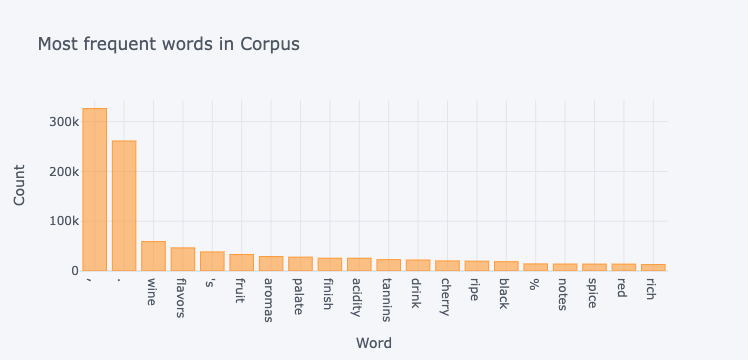

In [37]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [38]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))

Total of 3047494 words, 41318 unique words


In [39]:
print ("Using words with 4 or more appearances will reduce the corpus size to: {}".format(sum(words_df.wordCount >= 4)))

Using words with 4 or more appearances will reduce the corpus size to: 13954


In [40]:
words_df = words_df[words_df.wordCount >= 4]

#### Bag of words (One-hot-encoding) for Train

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
clean_vocab = set(words_df.word)

In [43]:
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)

In [44]:
clean_bow_counts_train = count_vect.fit_transform(train_data.desc_low)
clean_bow_counts_train

<95990x13954 sparse matrix of type '<class 'numpy.int64'>'
	with 2533144 stored elements in Compressed Sparse Row format>

In [45]:
clean_bow_counts_train.shape

(95990, 13954)

#### Bag of words (One-hot-encoding) for Test

In [46]:
clean_bow_counts_test = count_vect.fit_transform(test_data.desc_low)
clean_bow_counts_test

<23998x13954 sparse matrix of type '<class 'numpy.int64'>'
	with 631283 stored elements in Compressed Sparse Row format>

In [47]:
clean_bow_counts_test.shape

(23998, 13954)

### Regression (not Classification)

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error

In [49]:
from sklearn.linear_model import LinearRegression, Ridge

#### Search for the best alpha on the Train set only :

In [50]:
#%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, clean_bow_counts_train, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

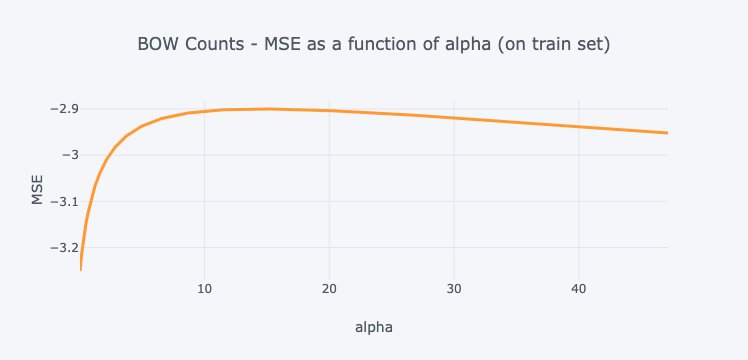

In [51]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [52]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

15.264179671752334 2.9000240534477664


#### Optimal Model : training the model with the best alpha, on the train set:

In [53]:

model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=15.264179671752334)

In [54]:
test_data['ridge_predicted_points'] = model.predict(clean_bow_counts_test)

In [55]:
ridge_stats = calc_prediction_quality(test_data, 'ridge_predicted_points','points')
ridge_stats

MSE    2.880460
MAE    1.339085
R2     0.698578
dtype: float64

In [56]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, ridge_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'ridge_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.556321,2.529918,-0.000008
baseline_2,9.055044,2.457114,0.052447
baseline_3,8.507232,2.364351,0.109772
regression_by_xgb,6.358655,1.906784,0.334607
ridge_stats,2.880460,1.339085,0.698578


In [59]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

### Using both the text and other features

#### Using both the text and other features (encoded in the Boosting trees part)

In [60]:
features

['country',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'variety',
 'winery',
 'price']

In [61]:
from scipy.sparse import coo_matrix, hstack

In [64]:
train_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87
5,38,263,758,6,12,591,14706,15.0,87
8,17,308,738,6,1,209,8415,12.0,87


In [66]:
train_encoded_features[features].head()

,country,province,region_1,region_2,taster_name,variety,winery,price
2,41,269,1218,17,15,437,13018,14.0
3,41,218,549,6,0,480,14390,13.0
4,41,269,1218,17,15,441,14621,65.0
5,38,263,758,6,12,591,14706,15.0
8,17,308,738,6,1,209,8415,12.0


In [68]:
train_encoded_features[features].shape

(95990, 8)

In [67]:
test_encoded_features[features].head()

,country,province,region_1,region_2,taster_name,variety,winery,price
0,22,332,424,6,9,691,11608,-1.0
1,32,108,738,6,16,451,12956,15.0
6,22,332,1205,6,9,186,15014,16.0
7,15,11,21,6,16,209,15395,24.0
9,15,11,21,6,16,437,8989,27.0


In [69]:
test_encoded_features[features].shape

(23998, 8)

In [70]:
train_features_spares_matrix = coo_matrix(train_encoded_features[features])
train_united_features = hstack((clean_bow_counts_train ,train_features_spares_matrix))

test_features_spares_matrix = coo_matrix(test_encoded_features[features])
test_united_features = hstack((clean_bow_counts_test ,test_features_spares_matrix))

#### Search for the best alpha on the Train set only :

In [71]:
#%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, train_united_features, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

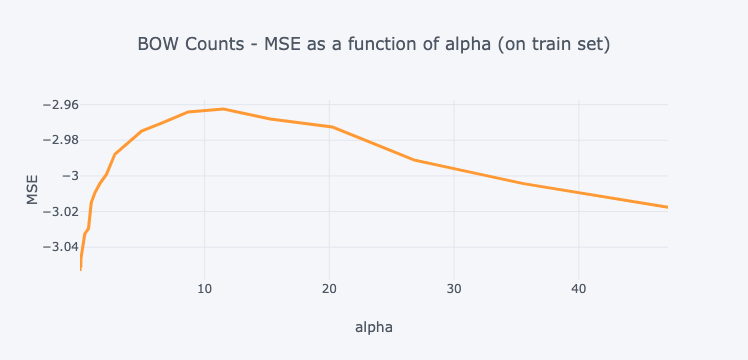

In [72]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [73]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

11.513953993264469 2.9624395901718192


#### Optimal Model : training the model with the best alpha, on the train set:

In [74]:
#
model = Ridge(alpha=opt_alpha)
model.fit(train_united_features, train_data.points)

Ridge(alpha=11.513953993264469)

In [75]:
test_data['ridge2_predicted_points'] = model.predict(test_united_features)

In [76]:
ridge2_stats = calc_prediction_quality(test_data, 'ridge2_predicted_points','points')
ridge2_stats

MSE    2.913012
MAE    1.346257
R2     0.695172
dtype: float64

In [77]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, ridge_stats, ridge2_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'ridge_stats', 'ridge2_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.556321,2.529918,-0.000008
baseline_2,9.055044,2.457114,0.052447
baseline_3,8.507232,2.364351,0.109772
regression_by_xgb,6.358655,1.906784,0.334607
ridge_stats,2.880460,1.339085,0.698578
ridge2_stats,2.913012,1.346257,0.695172


In [78]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

#### Are there outliars in the encoded features ?

country           AxesSubplot(0.125,0.657941;0.227941x0.222059)
province       AxesSubplot(0.398529,0.657941;0.227941x0.222059)
region_1       AxesSubplot(0.672059,0.657941;0.227941x0.222059)
region_2          AxesSubplot(0.125,0.391471;0.227941x0.222059)
taster_name    AxesSubplot(0.398529,0.391471;0.227941x0.222059)
variety        AxesSubplot(0.672059,0.391471;0.227941x0.222059)
winery               AxesSubplot(0.125,0.125;0.227941x0.222059)
price             AxesSubplot(0.398529,0.125;0.227941x0.222059)
points            AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

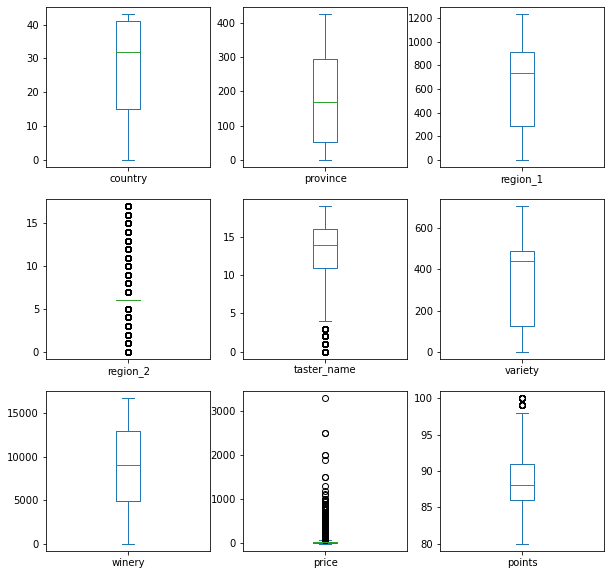

In [79]:
train_encoded_features.plot(kind='box', subplots=True, figsize=(10,10), layout=(3,3))

In [80]:
#removing the 'price' feature as it's showing a lot of outliars:
encoded_features2 = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features2['points'] = wine_reviews.points
encoded_features2.head()

,country,province,region_1,region_2,taster_name,variety,winery,points
0,22,332,424,6,9,691,11608,87
1,32,108,738,6,16,451,12956,87
2,41,269,1218,17,15,437,13018,87
3,41,218,549,6,0,480,14390,87
4,41,269,1218,17,15,441,14621,87


In [81]:
train_encoded_features2 = encoded_features2[encoded_features2.index.isin(train_data.index)]
test_encoded_features2 = encoded_features2[encoded_features2.index.isin(test_data.index)]
assert(len(train_encoded_features2) + len(test_encoded_features2) == len(wine_reviews))

In [82]:
features2 = ['country',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'variety',
 'winery']

In [83]:
train_encoded_features2.head()

,country,province,region_1,region_2,taster_name,variety,winery,points
2,41,269,1218,17,15,437,13018,87
3,41,218,549,6,0,480,14390,87
4,41,269,1218,17,15,441,14621,87
5,38,263,758,6,12,591,14706,87
8,17,308,738,6,1,209,8415,87


In [84]:
test_encoded_features2.head()

,country,province,region_1,region_2,taster_name,variety,winery,points
0,22,332,424,6,9,691,11608,87
1,32,108,738,6,16,451,12956,87
6,22,332,1205,6,9,186,15014,87
7,15,11,21,6,16,209,15395,87
9,15,11,21,6,16,437,8989,87


In [85]:
train_features_spares_matrix2 = coo_matrix(train_encoded_features2[features2])
train_united_features2 = hstack((clean_bow_counts_train ,train_features_spares_matrix2))

test_features_spares_matrix2 = coo_matrix(test_encoded_features2[features2])
test_united_features2 = hstack((clean_bow_counts_test ,test_features_spares_matrix2))

In [86]:
train_united_features2

<95990x13961 sparse matrix of type '<class 'numpy.int64'>'
	with 3199836 stored elements in COOrdinate format>

In [87]:
test_united_features2

<23998x13961 sparse matrix of type '<class 'numpy.int64'>'
	with 798063 stored elements in COOrdinate format>

In [88]:
#%%capture
search_grid2 = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha2 = []
for alpha in search_grid2:
    model2 = Ridge(alpha=alpha)
    avg_score2 = cross_val_score(model2, train_united_features2, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha2.append((alpha,avg_score2))

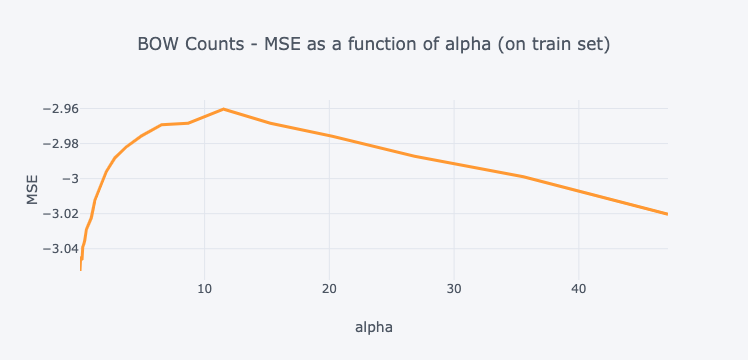

In [89]:
cv_results2 = pd.DataFrame(MSE_by_alpha2, columns = ['alpha', 'MSE'])
cv_results2.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [90]:
opt_alpha2, max_MSE2 = cv_results2.loc[cv_results2.MSE.idxmax()]
print(opt_alpha2, -max_MSE2)

11.513953993264469 2.9602870785596553


In [91]:
model = Ridge(alpha=opt_alpha2)
model.fit(train_united_features2, train_data.points)

Ridge(alpha=11.513953993264469)

In [92]:
test_data['ridge3_predicted_points'] = model.predict(test_united_features2)

In [93]:
ridge3_stats = calc_prediction_quality(test_data, 'ridge3_predicted_points','points')
ridge3_stats

MSE    2.915827
MAE    1.346869
R2     0.694877
dtype: float64

In [94]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, ridge_stats, ridge2_stats, ridge3_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'ridge_stats', 'ridge2_stats', 'ridge3_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.556321,2.529918,-0.000008
baseline_2,9.055044,2.457114,0.052447
baseline_3,8.507232,2.364351,0.109772
regression_by_xgb,6.358655,1.906784,0.334607
ridge_stats,2.880460,1.339085,0.698578
ridge2_stats,2.913012,1.346257,0.695172
ridge3_stats,2.915827,1.346869,0.694877


In [95]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

Although we removed the "price" feature that had many outliers, it worsened improve the performance.

## Deep Learning approaches

### Fully connected network on the text only

#### Tokenization

In [96]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [97]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [98]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

2022-05-31 12:16:15.390747: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [99]:
vectorize_layer.adapt(train_data['description'])

In [100]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

This is a soft wine although one with a tangy backdrop that makes it both smooth and crisp. Its citrus fruitiness has a touch of pepper as well as minerality. The elements have come together into a bright tangy wine to drink now.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([   7,    8,    4,   46,    9,  278,  157,    6,    4,  226, 1174,
         19,  292,   13,  291,   96,    2,   51,   14,   61,  325,   30,
          4,   78,    5,   70,   37,   66,   37,  220,    3,  517,  274,
        194,  306,  110,    4,   62,  226,    9,   12,   25,   44,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])>

In [101]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

7 --->  this
8 --->  is
4 --->  a
46 --->  soft
9 --->  wine
278 --->  although
157 --->  one
6 --->  with
4 --->  a
226 --->  tangy
1174 --->  backdrop
19 --->  that
292 --->  makes
13 --->  it
291 --->  both
96 --->  smooth
2 --->  and
51 --->  crisp
14 --->  its
61 --->  citrus


#### Modeling

In [102]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [103]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout (Dropout)           (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 1

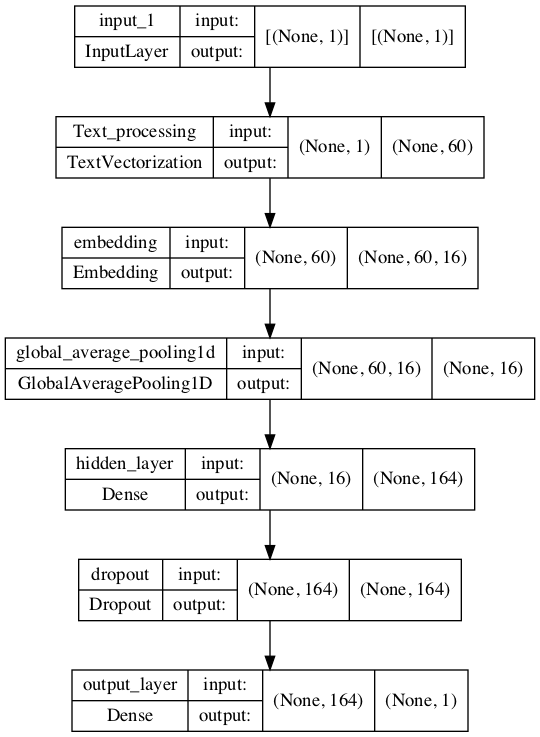

In [104]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [105]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [106]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 14s 17ms/step - loss: 22.1010 - mean_squared_error: 1366.4484 - mean_absolute_error: 22.1010 - val_loss: 2.4835 - val_mean_squared_error: 9.3548 - val_mean_absolute_error: 2.4835
Epoch 2/20
750/750 [==============================] - 11s 15ms/step - loss: 3.4734 - mean_squared_error: 18.8704 - mean_absolute_error: 3.4734 - val_loss: 1.7178 - val_mean_squared_error: 4.6626 - val_mean_absolute_error: 1.7178
Epoch 3/20
750/750 [==============================] - 11s 15ms/step - loss: 3.1739 - mean_squared_error: 15.9257 - mean_absolute_error: 3.1739 - val_loss: 1.5162 - val_mean_squared_error: 3.6698 - val_mean_absolute_error: 1.5162
Epoch 4/20
750/750 [==============================] - 12s 16ms/step - loss: 3.1225 - mean_squared_error: 15.3539 - mean_absolute_error: 3.1225 - val_loss: 1.4548 - val_mean_squared_error: 3.3813 - val_mean_absolute_error: 1.4548
Epoch 5/20
750/750 [==============================] - 11s 15ms/step - loss: 3.07

#### Simple NN Prediction & Evaluation

In [107]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

In [108]:
dnn_stats = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
dnn_stats

MSE    3.080886
MAE    1.384379
R2     0.677605
dtype: float64

In [109]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, ridge_stats, ridge2_stats, ridge3_stats, dnn_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'ridge_stats', 'ridge2_stats', 'ridge3_stats', 'dnn_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.556321,2.529918,-0.000008
baseline_2,9.055044,2.457114,0.052447
baseline_3,8.507232,2.364351,0.109772
regression_by_xgb,6.358655,1.906784,0.334607
ridge_stats,2.880460,1.339085,0.698578
ridge2_stats,2.913012,1.346257,0.695172
ridge3_stats,2.915827,1.346869,0.694877
dnn_prediction,3.080886,1.384379,0.677605


#### Descriptions words concatinated

In [110]:
from tensorflow.keras.layers import Reshape, Dense, Dropout
from tensorflow.keras import Sequential

In [215]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(800, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [216]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

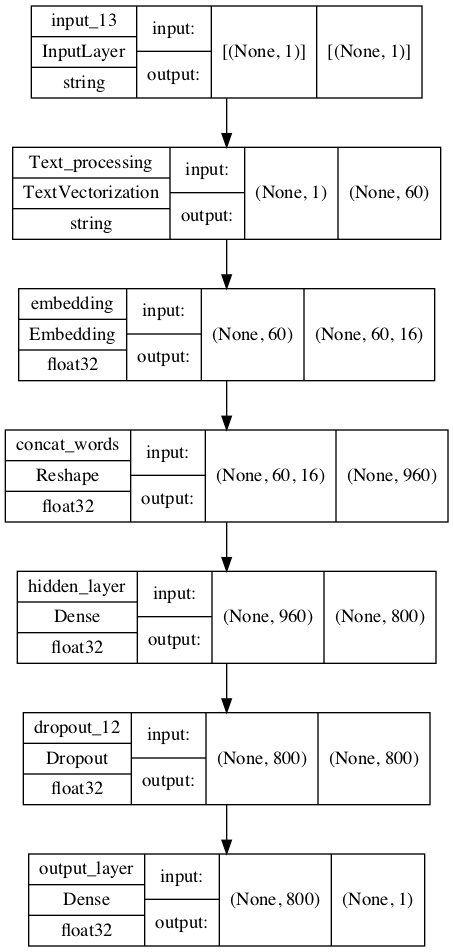

In [217]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [218]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 65s 77ms/step - loss: 6.4023 - mean_squared_error: 266.4514 - mean_absolute_error: 6.4023 - val_loss: 1.7648 - val_mean_squared_error: 4.8925 - val_mean_absolute_error: 1.7648
Epoch 2/20
750/750 [==============================] - 50s 67ms/step - loss: 1.9462 - mean_squared_error: 6.0088 - mean_absolute_error: 1.9462 - val_loss: 1.4905 - val_mean_squared_error: 3.5685 - val_mean_absolute_error: 1.4905
Epoch 3/20
750/750 [==============================] - 53s 71ms/step - loss: 1.8329 - mean_squared_error: 5.3188 - mean_absolute_error: 1.8329 - val_loss: 1.4159 - val_mean_squared_error: 3.1884 - val_mean_absolute_error: 1.4159
Epoch 4/20
750/750 [==============================] - 50s 67ms/step - loss: 1.7811 - mean_squared_error: 5.0237 - mean_absolute_error: 1.7811 - val_loss: 1.3654 - val_mean_squared_error: 2.9901 - val_mean_absolute_error: 1.3654
Epoch 5/20
750/750 [==============================] - 53s 70ms/step - loss: 1.7486 - m

In [219]:
test_data['dnn2_prediction'] = model.predict(test_data[text_col])

In [220]:
dnn2_stats = calc_prediction_quality(test_data, 'dnn2_prediction', target_col)
dnn2_stats

MSE    2.990146
MAE    1.365421
R2     0.687100
dtype: float64

In [221]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, ridge_stats, ridge2_stats, ridge3_stats, dnn_stats, dnn2_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'ridge_stats', 'ridge2_stats', 'ridge3_stats', 'dnn_prediction', 'dnn2_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.556321,2.529918,-0.000008
baseline_2,9.055044,2.457114,0.052447
baseline_3,8.507232,2.364351,0.109772
regression_by_xgb,6.358655,1.906784,0.334607
ridge_stats,2.880460,1.339085,0.698578
ridge2_stats,2.913012,1.346257,0.695172
ridge3_stats,2.915827,1.346869,0.694877
dnn_prediction,3.080886,1.384379,0.677605
dnn2_prediction,2.990146,1.365421,0.687100


When we use the Concatenation technique and increase the number of neurons, we improve the performance vs the averaged technique.

### Using external embedding (description feature only)

#### First trial

Follow https://keras.io/examples/nlp/pretrained_word_embeddings/

You can either average the description words embeddings, concatinate them or do both and compare. 

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

In [119]:
import os
import urllib.request
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.manifold import TSNE
import numpy as np

In [100]:
#urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

('glove.6B.zip', <http.client.HTTPMessage at 0x7f80329ad940>)

In [133]:
emmbed_dict = {}
with open('/Users/charrlel/machine_learning/Python_ML-2022/Final project/glove.6B/glove.6B.300d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector


In [134]:
print("Found %s word vectors." % len(emmbed_dict))

Found 400000 word vectors.


In [135]:
def find_similar_word(emmbedes):
  nearest = sorted(emmbed_dict.keys(), key=lambda word: spatial.distance.euclidean(emmbed_dict[word], emmbedes))
  return nearest

find_similar_word(emmbed_dict['river'])[0:10]

['river',
 'rivers',
 'tributary',
 'confluence',
 'valley',
 'flows',
 'along',
 'creek',
 'estuary',
 'tributaries']

In [136]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [137]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = emmbed_dict.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19427 words (12573 misses)


In [138]:
#from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [165]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.3),
    Dense(1, name = 'output_layer')
])

In [166]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding_1 (Embedding)     (None, 60, 300)           9600600   
                                                                 
 global_average_pooling1d_4   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 164)               49364     
                                                                 
 dropout_5 (Dropout)         (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                

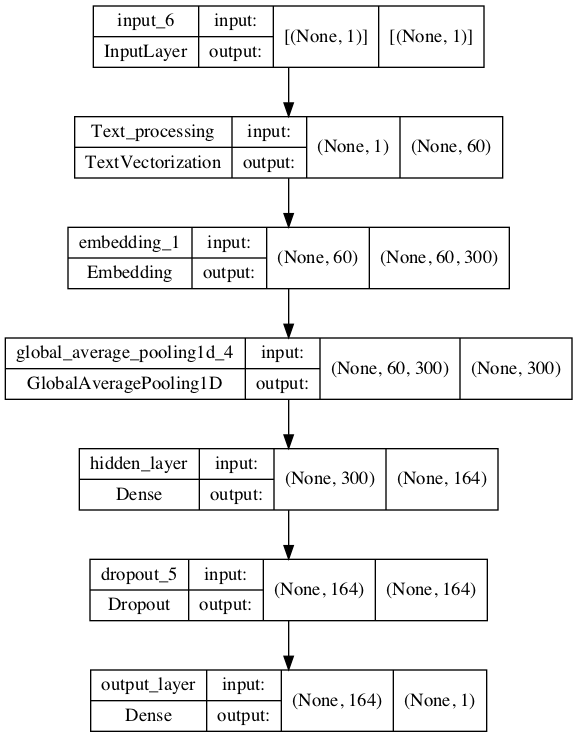

In [167]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [168]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [169]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=64,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
1500/1500 [==============================] - 14s 8ms/step - loss: 13.3693 - mean_squared_error: 579.6868 - mean_absolute_error: 13.3693 - val_loss: 2.3729 - val_mean_squared_error: 9.0231 - val_mean_absolute_error: 2.3729
Epoch 2/20
1500/1500 [==============================] - 11s 7ms/step - loss: 4.2397 - mean_squared_error: 28.3230 - mean_absolute_error: 4.2397 - val_loss: 1.9502 - val_mean_squared_error: 6.1664 - val_mean_absolute_error: 1.9502
Epoch 3/20
1500/1500 [==============================] - 12s 8ms/step - loss: 4.0237 - mean_squared_error: 25.5706 - mean_absolute_error: 4.0237 - val_loss: 1.8296 - val_mean_squared_error: 5.4078 - val_mean_absolute_error: 1.8296
Epoch 4/20
1500/1500 [==============================] - 12s 8ms/step - loss: 3.9778 - mean_squared_error: 24.9882 - mean_absolute_error: 3.9778 - val_loss: 1.7239 - val_mean_squared_error: 4.7656 - val_mean_absolute_error: 1.7239
Epoch 5/20
1500/1500 [==============================] - 12s 8ms/step - loss: 

In [170]:
test_data['ext_emb_prediction'] = model.predict(test_data[text_col])

In [171]:
ext_emb_stats = calc_prediction_quality(test_data, 'ext_emb_prediction', target_col)
ext_emb_stats

MSE    4.379642
MAE    1.664745
R2     0.541698
dtype: float64

In [222]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, ridge_stats, ridge2_stats, dnn_stats, dnn2_stats, ext_emb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'ridge_stats', 'ridge2_stats', 'dnn_prediction', 'dnn2_prediction', 'ext_emb_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.556321,2.529918,-0.000008
baseline_2,9.055044,2.457114,0.052447
baseline_3,8.507232,2.364351,0.109772
regression_by_xgb,6.358655,1.906784,0.334607
ridge_stats,2.880460,1.339085,0.698578
ridge2_stats,2.913012,1.346257,0.695172
dnn_prediction,3.080886,1.384379,0.677605
dnn2_prediction,2.990146,1.365421,0.687100
ext_emb_prediction,4.379642,1.664745,0.541698


### Using LSTM or RNN Layer, (description feature only)

See example here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

In [173]:
from keras.layers import LSTM

In [200]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, input_length = sequence_length, name="embedding"),
    #Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    LSTM(units=64,name='lstm_hidden_layer'),
    #Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [201]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 lstm_hidden_layer (LSTM)    (None, 64)                20736     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 532,801
Trainable params: 532,801
Non-trainable params: 0
_______________________________________________

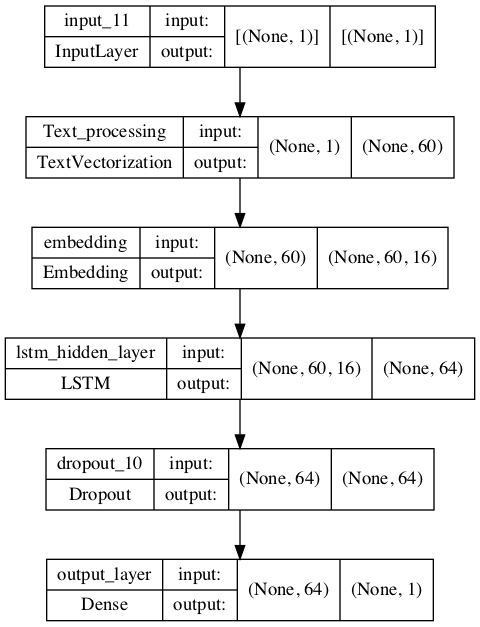

In [202]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [203]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [204]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=32,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
3000/3000 [==============================] - 178s 58ms/step - loss: 19.0796 - mean_squared_error: 880.3806 - mean_absolute_error: 19.0796 - val_loss: 2.5102 - val_mean_squared_error: 9.7655 - val_mean_absolute_error: 2.5102
Epoch 2/20
3000/3000 [==============================] - 171s 57ms/step - loss: 5.0422 - mean_squared_error: 40.0174 - mean_absolute_error: 5.0422 - val_loss: 2.5284 - val_mean_squared_error: 9.8566 - val_mean_absolute_error: 2.5284
Epoch 3/20
3000/3000 [==============================] - 181s 60ms/step - loss: 5.0309 - mean_squared_error: 39.7842 - mean_absolute_error: 5.0309 - val_loss: 2.5069 - val_mean_squared_error: 9.7268 - val_mean_absolute_error: 2.5069
Epoch 4/20
3000/3000 [==============================] - 152s 51ms/step - loss: 4.9775 - mean_squared_error: 38.9291 - mean_absolute_error: 4.9775 - val_loss: 2.4930 - val_mean_squared_error: 9.2291 - val_mean_absolute_error: 2.4930
Epoch 5/20
3000/3000 [==============================] - 126s 42ms/ste

In [205]:
test_data['lstm_prediction'] = model.predict(test_data[text_col])

In [206]:
lstm_stats = calc_prediction_quality(test_data, 'lstm_prediction', target_col)
lstm_stats

MSE    3.473574
MAE    1.479632
R2     0.636513
dtype: float64

The best result I had obtained so far with : lstm layer 64 neurons: fit: 20 epochs, batch size 32 :

MSE    3.200008

MAE    1.413811

R2     0.664620

dtype: float64

But after running again, I have different results and I can't figure out why.

In [223]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, ridge_stats, ridge2_stats,ridge3_stats, dnn_stats, dnn2_stats, ext_emb_stats, lstm_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'ridge_stats', 'ridge2_stats', 'ridge3_stats', 'dnn_stats', 'dnn2_stats', 'ext_emb_stats', 'lstm_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.556321,2.529918,-0.000008
baseline_2,9.055044,2.457114,0.052447
baseline_3,8.507232,2.364351,0.109772
regression_by_xgb,6.358655,1.906784,0.334607
ridge_stats,2.880460,1.339085,0.698578
ridge2_stats,2.913012,1.346257,0.695172
ridge3_stats,2.915827,1.346869,0.694877
dnn_stats,3.080886,1.384379,0.677605
dnn2_stats,2.990146,1.365421,0.687100
ext_emb_stats,4.379642,1.664745,0.541698


### Bonus (Not mandatory) Use all features using Keras functional API

See here: https://keras.io/guides/functional_api/

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>